## Gradient Descent for Life Insurance Premiums

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

### Constants

In [4]:
YEARS = 20

# discount rate
DISCOUNT = torch.full((YEARS,), 0.05)

# policy values
INITIAL_BALANCE = 209000.0 
DEATH_BENEFIT = 1000000.0
COI = torch.tensor([
    25.3835,
    28.7676,
    32.2841,
    36.1080,
    40.0561,
    44.9284,
    49.7497,
    56.7585,
    65.8140,
    75.9054,
    86.8502,
    98.5907,
    110.7127,
    123.0529,
    134.7429,
    155.6109,
    175.6953,
    198.0022,
    222.6517,
    249.7688
])
INTEREST_RATE = torch.full((YEARS,), 0.0564)

# mortality statistics
BASE_MORTALITY = torch.tensor([0.004056, 0.006672, 0.011776, 0.017520, 0.022664, 0.028984, 0.037968, 0.049360, 0.064032, 0.083352, 0.108296, 0.127832, 0.140240, 0.152200, 0.163152, 0.174760, 0.188432, 0.203136, 0.218912, 0.235448])
ANNUAL_IMPROVEMENT_FACTOR = torch.full((YEARS,), 0.01)
SHOCK_FACTOR = torch.zeros((YEARS,))



### Input

In [46]:
premiums = torch.full((20,), 20000.0)
# premiums = torch.full((20,), 35000.0)

premiums.requires_grad_()

tensor([20000., 20000., 20000., 20000., 20000., 20000., 20000., 20000., 20000.,
        20000., 20000., 20000., 20000., 20000., 20000., 20000., 20000., 20000.,
        20000., 20000.], requires_grad=True)

### Compute Policy Premiums

Find ending balance and effect on death rate, given premiums schedule.

In [6]:
def calculate_balance(premiums):
    balance_boy = torch.zeros((YEARS + 1,))
    balance_boy[0] = INITIAL_BALANCE
    PERCENT_PREMIUM_CHARGE = torch.full((YEARS,), 0.02)
    POLICY_FEE = torch.full((YEARS,), 150.0)
    for i in range(YEARS):
        premium_charge = -premiums[i] * PERCENT_PREMIUM_CHARGE[i]
        net_at_risk = DEATH_BENEFIT - premiums[i] - balance_boy[i] - premium_charge + POLICY_FEE[i]
        cost_of_insurance = - COI[i] * net_at_risk / 1000
        partial_sum = balance_boy[i] + premiums[i] + premium_charge - POLICY_FEE[i] + cost_of_insurance
        balance_boy[i+1] = (partial_sum) * (1 + INTEREST_RATE[i])
        
    return balance_boy
        
print(calculate_balance(premiums))
    

tensor([  209000.0000,   199414.3594,   186168.4531,   168749.1250,
          146394.7656,   118366.0938,    83031.9375,    39356.8086,
          -16190.7793,   -87924.4219,  -180290.6875,  -298921.2812,
         -451238.7812,  -646597.0625,  -897289.3750, -1218141.1250,
        -1651661.8750, -2237162.5000, -3040644.2500, -4162727.5000,
        -5759919.0000], grad_fn=<CopySlices>)


### Compute Expected Present Value

In [7]:
# get boy and eoy discount factors
def discount_factors():
    
    discount_boy = torch.empty((YEARS+1,))
    discount_boy[0] = 1
    for i in range(1, YEARS + 1):
        discount_boy[i] = discount_boy[i-1] / (1 + DISCOUNT[i-1])
        
    return discount_boy, discount_boy[1:]

print(discount_factors())

(tensor([1.0000, 0.9524, 0.9070, 0.8638, 0.8227, 0.7835, 0.7462, 0.7107, 0.6768,
        0.6446, 0.6139, 0.5847, 0.5568, 0.5303, 0.5051, 0.4810, 0.4581, 0.4363,
        0.4155, 0.3957, 0.3769]), tensor([0.9524, 0.9070, 0.8638, 0.8227, 0.7835, 0.7462, 0.7107, 0.6768, 0.6446,
        0.6139, 0.5847, 0.5568, 0.5303, 0.5051, 0.4810, 0.4581, 0.4363, 0.4155,
        0.3957, 0.3769]))


In [8]:
# get probability of boy survival and eoy death 
def actuarial_factors():
    cumulative_improvement_factor = 1 - ANNUAL_IMPROVEMENT_FACTOR
    adj_rate_one = BASE_MORTALITY * cumulative_improvement_factor
    adj_rate_two = adj_rate_one * (1 + SHOCK_FACTOR)

    survivors_boy = torch.zeros((YEARS + 1,))
    deaths_eoy = torch.zeros((YEARS,))
    survivors_boy[0] = 1.0  # Start with 100% at BOY

    # iteratively find death and survival rates based on previous year results
    for i in range(YEARS):
        deaths_eoy[i] = survivors_boy[i] * adj_rate_two[i]
        survivors_boy[i + 1] = survivors_boy[i] - deaths_eoy[i]

    # we assume all remaining living people die on the last year / collect on the policy
    deaths_eoy[YEARS - 1] = survivors_boy[YEARS - 1]
    return survivors_boy[:-1], deaths_eoy

# inaccurate way that Excel calculates, with too low precision
def excel_actuarial_factors():
    MORTALITY = torch.tensor([1.0000, 0.9960, 0.9895, 0.9782, 0.9617, 0.9410, 0.9153, 0.8829, 0.8427, 0.7934, 0.7336, 0.6625, 0.5874, 0.5151, 0.4470, 0.3843, 0.3271, 0.2751, 0.2285, 0.1872, 0.0])
    survival_boy = MORTALITY[:-1]
    death_eoy = MORTALITY[:-1] - MORTALITY[1:]
    return survival_boy, death_eoy

print([i*1000000 for i in excel_actuarial_factors()[1]])
print([i*1000000 for i in actuarial_factors()[1]])

[tensor(4000.0081), tensor(6500.0059), tensor(11299.9678), tensor(16499.9961), tensor(20700.0371), tensor(25699.9727), tensor(32400.0117), tensor(40199.9961), tensor(49300.0156), tensor(59799.9688), tensor(71100.), tensor(75100.0078), tensor(72300.0156), tensor(68100.0078), tensor(62700.0039), tensor(57199.9844), tensor(52000.0156), tensor(46600.), tensor(41300.), tensor(187200.)]
[tensor(4015.4402), tensor(6578.7568), tensor(11534.7305), tensor(16960.9766), tensor(21560.2852), tensor(26953.8535), tensor(34295.4297), tensor(42909.6055), tensor(52944.1523), tensor(64549.8125), tensor(76946.4688), tensor(81089.3203), tensor(77702.0078), tensor(72620.6250), tensor(66116.5391), tensor(59381.6484), tensor(52949.7383), tensor(46433.1523), tensor(39976.1328), tensor(144481.2188)]


In [76]:
def positive_balance_years(premiums):

    balance_eoy = calculate_balance(torch.nn.ReLU()(premiums))[1:]
    negative_balance_years = torch.where(balance_eoy < 0)[0]
    
    if len(negative_balance_years) > 0:
        return negative_balance_years[0].item()
    
    return YEARS

# find net expected present value of insurance policy
# use_excel_rounding rounds the actuarial factors to 4 sig figs after each calculation. set True to test against Excel spreadsheet, keep False for higher accuracy
def calculate_expected_present_value(premiums, use_excel_rounding = False, change_death_benefit = False, print_output = False):
    
    death_benefit = torch.full((YEARS,), DEATH_BENEFIT)
        
    # set death benefit to 0 if the policy has ever been in a negative balance
    if change_death_benefit:
        death_benefit[positive_balance_years(premiums):] = 0
    
    discount_boy, discount_eoy = discount_factors()
    survival_boy, death_eoy = excel_actuarial_factors() if use_excel_rounding else actuarial_factors()
    
    premium_cash_flow_boy = premiums * survival_boy
    death_benefit_cash_flow_eoy = death_benefit * death_eoy
    
    if print_output:
        print("Premium Cash Flow (BOY):")
        for idx, val in enumerate(premium_cash_flow_boy):
            print(f"  Year {idx+1:2d}: {val:12,.2f}")
        print("Death Benefit Cash Flow (EOY):")
        for idx, val in enumerate(death_benefit_cash_flow_eoy):
            print(f"  Year {idx+1:2d}: {val:12,.2f}")
        
    # compute net cash flow via offsetting death_benefit_cash_flow_eoy and premium_cash_flow_boy
    net_cash_flow_boy = (
        torch.cat((torch.tensor([0.0]), death_benefit_cash_flow_eoy)) - 
        torch.cat((premium_cash_flow_boy, torch.tensor([0.0]))))
    
    return torch.sum(discount_boy * net_cash_flow_boy)

print(calculate_expected_present_value(premiums, use_excel_rounding=True, change_death_benefit=True).item())
print(positive_balance_years(premiums))

110908.765625
13


### Loss Function

In [59]:
def piecewise_loss(premiums):

    balance_boy = calculate_balance(premiums)
    expected_present_value = calculate_expected_present_value(premiums) 
    
    if balance_boy[-1] < -1:
        return -balance_boy[-1]
    
    return -expected_present_value

# loss is expected present value (where policy expires if ever in negative balance) + negative balance at the end of the policy
def expiration_loss(premiums):
    
    balance_boy = calculate_balance(premiums)
    expected_present_value = calculate_expected_present_value(premiums, change_death_benefit=True) 
    return -(expected_present_value + torch.min(balance_boy[-1], torch.tensor(0.0)))

# loss is expected present value of policy (through completion of the policy) + (weighted) negative balance at the end of the policy
def smooth_loss(premiums, balance_activation_function=torch.nn.ReLU()):

    balance_boy = calculate_balance(torch.nn.ReLU()(premiums))
    expected_present_value = calculate_expected_present_value(torch.nn.ReLU()(premiums)) 

    return -expected_present_value + balance_activation_function(-balance_boy[-1])

print(f"{'Expiration Loss:':20s} {round(expiration_loss(premiums).item(), 4):15.4f}")
print(f"{'Piecewise Loss:':20s} {round(piecewise_loss(premiums).item(), 4):15.4f}")
print(f"{'Smooth Loss:':20s} {round(smooth_loss(premiums).item(), 4):15.4f}")

Expiration Loss:        2199576.2500
Piecewise Loss:         2334602.5000
Smooth Loss:            1991222.0000


### Gradient Descent

In [82]:



# Set the random seed for reproducibility
torch.manual_seed(0)

premiums_input = torch.rand((20,)) * 50000.0
premiums_input = torch.tensor([  64325.35,   69509.91,   26700.43,   20355.28,   21075.45,   29642.84,   15130.02,   29626.19,    3549.79,   10798.93,    0,   10395.28,    3672.41,   23879.62,   43402.56,   68104.01,   88680.91,  104796.06,   83182.37,   99041.80])

premiums_input.requires_grad_()

optimizer = torch.optim.Adam([premiums_input], lr=2)
n_iters = 500000
losses = []
for i in range(n_iters):
    optimizer.zero_grad()
    loss_value = smooth_loss(premiums_input, balance_activation_function=torch.nn.ELU(5.0))
    losses.append((loss_value.item(), positive_balance_years(premiums_input)))

    loss_value.backward()
    optimizer.step()
    progress = int(50 * (i + 1) / n_iters)
    bar = '[' + '#' * progress + '-' * (50 - progress) + ']'
    print(f"\rProgress: {bar} {100 * (i + 1) / n_iters:.2f}%", end='', flush=True)
    if i % (n_iters / 100) == 0:
        rounded_loss = round(loss_value.item(), 4)
        pos_years = positive_balance_years(premiums_input)
        rounded_premiums = [round(float(p), 2) for p in premiums_input.tolist()]
        # Format: Loss (12 chars, right), Years (3 chars, right), Premiums (each 10 chars, right)
        premiums_str = "[" + ", ".join(f"{p:10.2f}" for p in rounded_premiums) + "]"
        print(f"\rIteration {i:6d}: Loss = {rounded_loss:12.4f}, Positive Balance Years = {pos_years:3d}, Premiums = {premiums_str}")
        
# Plot the loss curve from gradient descent
plt.plot([x[0] for x in losses])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Curve During Gradient Descent")
plt.show()
plt.plot([x[1] for x in losses])
plt.xlabel("Iteration")
plt.ylabel("Positive Balance Years")
plt.title("Positive Balance Years During Gradient Descent")
plt.show()

Iteration      0: Loss = -225976.0625, Positive Balance Years =  20, Premiums = [  64323.35,   69507.91,   26698.43,   20353.28,   21073.45,   29640.84,   15128.02,   29624.19,    3547.79,   10796.93,       0.00,   10393.28,    3670.41,   23877.62,   43400.56,   68102.01,   88678.91,  104794.06,   83180.37,   99039.80]
Progress: [--------------------------------------------------] 0.17%

KeyboardInterrupt: 

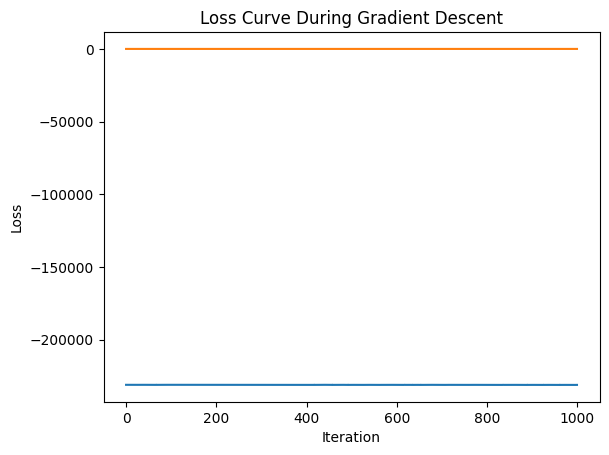

[(-231035.0625, 20), (-231032.71875, 20), (-231031.609375, 20), (-231031.5625, 20), (-231032.46875, 20), (-231034.265625, 20), (-231036.84375, 20), (-231040.125, 20), (-231044.0625, 20), (-231048.546875, 20), (-231053.5625, 20), (-231059.0625, 20), (-231064.96875, 20), (-231013.78125, 19), (-231060.6875, 20), (-231052.109375, 20), (-231045.359375, 20), (-231040.234375, 20), (-231036.59375, 20), (-231034.265625, 20), (-231033.125, 20), (-231033.09375, 20), (-231034.015625, 20), (-231035.78125, 20), (-231038.390625, 20), (-231041.671875, 20), (-231045.578125, 20), (-231050.09375, 20), (-231055.09375, 20), (-231060.59375, 20), (-231066.515625, 20), (-231001.984375, 19), (-231062.21875, 20), (-231053.640625, 20), (-231046.890625, 20), (-231041.765625, 20), (-231038.125, 20), (-231035.8125, 20), (-231034.671875, 20), (-231034.625, 20), (-231035.53125, 20), (-231037.328125, 20), (-231039.90625, 20), (-231043.1875, 20), (-231047.109375, 20), (-231051.625, 20), (-231056.65625, 20), (-231062.14

In [64]:
plt.plot(losses[-1000:])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Curve During Gradient Descent")
plt.show()
print(losses[-1000:])

### Bug Fixing

In [75]:
premiums_test = torch.tensor([73013.24,   75275.59,   29386.63,   20070.67,   17985.35,   23847.60,    6783.84,   19253.43,      -8.15,      -7.85,    -856.59,    1939.32,      -7.64,   24178.80,   48327.90,   77734.80,  102350.94,  122294.88,  104284.18,  123558.51])
premiums_test = torch.nn.ReLU()(premiums_test)
# for i in premiums_test:
#     print(f"{i.item()}")
# print(f"Loss for test: {smooth_loss(premiums_test, balance_activation_function=torch.nn.ELU(5.0)).item()}")
print(f"Expected Present Value for test: {calculate_expected_present_value(premiums_test, change_death_benefit=False).item()}")


Premium Cash Flow (BOY):
  Year  1:    73,013.24
  Year  2:    74,973.33
  Year  3:    29,075.30
  Year  4:    19,626.53
  Year  5:    17,282.30
  Year  6:    22,401.24
  Year  7:     6,189.55
  Year  8:    16,906.45
  Year  9:         0.00
  Year 10:         0.00
  Year 11:         0.00
  Year 12:     1,242.62
  Year 13:         0.00
  Year 14:    11,653.19
  Year 15:    19,782.47
  Year 16:    26,680.29
  Year 17:    29,051.31
  Year 18:    28,236.73
  Year 19:    19,235.98
  Year 20:    17,851.88
Death Benefit Cash Flow (EOY):
  Year  1:     4,015.44
  Year  2:     6,578.76
  Year  3:    11,534.73
  Year  4:    16,960.98
  Year  5:    21,560.29
  Year  6:    26,953.85
  Year  7:    34,295.43
  Year  8:    42,909.61
  Year  9:    52,944.15
  Year 10:    64,549.81
  Year 11:    76,946.47
  Year 12:    81,089.32
  Year 13:    77,702.01
  Year 14:    72,620.62
  Year 15:    66,116.54
  Year 16:    59,381.65
  Year 17:    52,949.74
  Year 18:    46,433.15
  Year 19:    39,976.13
  Year 2